In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.io import fits
from astropy.modeling import models, fitting

from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry

In [2]:
def load_data(file_s3d, file_x1d):

    wave = fits.getdata(file_x1d)['WAVELENGTH']
    
    hdu = fits.open(file_s3d)
    cube     = hdu['SCI'].data
    cube_err = hdu['ERR'].data

    pixel_area = hdu['SCI'].header['PIXAR_SR']
    cube     *= pixel_area * 1e6 # Convert to flux [MJy/sr] -> [Jy]
    cube_err *= pixel_area * 1e6

    return wave, cube, cube_err

def load_data_Miles_ea_2023(filename):

    wave, flux, flux_err = np.loadtxt(filename).T
    return wave, flux, flux_err
    
def aperture_extraction(image, positions, a, b, theta, image_err=None):

    aperture = EllipticalAperture(positions=positions, a=a, b=b, theta=theta)
    phot_table = aperture_photometry(image, aperture, error=image_err)

    if image_err is None:
        return phot_table['aperture_sum'].data[0], np.nan
    return phot_table['aperture_sum'].data[0], phot_table['aperture_sum_err'].data[0]

def fit_gaussian_2d(cube, xy_guess, inf_coeff=5, plot=False):

    # Median-combine the cube along the wavelength axis
    median_image = np.nanmedian(cube, axis=0)
    median_image[np.isnan(median_image)] = 0.
    median_image /= np.nanmax(median_image)

    # Fit a 2D Gaussian to the median image
    y, x = np.mgrid[:median_image.shape[0], :median_image.shape[1]]
    fitter = fitting.LevMarLSQFitter()

    # Define the initial guess for the Gaussian parameters
    g_init = models.Gaussian2D(amplitude=1., x_mean=xy_guess[0], y_mean=xy_guess[1], x_stddev=1., y_stddev=1., theta=0.)
    g_init.y_stddev.tied = lambda m: m.x_stddev
    g_init.theta.fixed = True

    # Fit the model to the data
    g_fit = fitter(g_init, x, y, median_image)
    model_image = g_fit(x, y)

    if plot:
        # Plot the results
        fig, ax = plt.subplots(figsize=(10,2.7), ncols=3)
        ax[0].imshow(median_image, vmin=-g_fit.amplitude*1., vmax=g_fit.amplitude*1.)
        ax[1].imshow(median_image-model_image , cmap='bwr', vmin=-g_fit.amplitude*1., vmax=g_fit.amplitude*1.)

        # Plot the fitted Gaussian
        e_kwargs = dict(xy=(g_fit.x_mean.value, g_fit.y_mean.value), angle=g_fit.theta.value*180/np.pi, ec='k', fc='none', lw=0.5, )
        e = [
            Ellipse(width=2*g_fit.x_stddev.value, height=2*g_fit.y_stddev.value, **e_kwargs), 
            Ellipse(width=inf_coeff*2*g_fit.x_stddev.value, height=inf_coeff*2*g_fit.y_stddev.value, **e_kwargs),
        ]
        [ax[0].add_artist(e_i) for e_i in e]

        # Plot the aperture sum as a function of the aperture size
        aper_kwargs = dict(image=median_image, positions=(g_fit.x_mean.value, g_fit.y_mean.value), theta=g_fit.theta.value)
        for sigma_coeff in range(1,10):
            flux, _ = aperture_extraction(a=g_fit.x_stddev.value*sigma_coeff, b=g_fit.y_stddev.value*sigma_coeff, **aper_kwargs)
            ax[2].plot(sigma_coeff, flux, 'o')
        ax[2].axvline(inf_coeff, color='black', ls='--')
        plt.show()

    return g_fit

def extract_1d(wave, cube, cube_err, aper_kwargs, plot=False):

    flux     = np.zeros_like(wave)
    flux_err = np.zeros_like(wave)
    for i in range(len(wave)):
        flux[i], flux_err[i] = aperture_extraction(image=cube[i], image_err=cube_err[i], **aper_kwargs)

    if plot:
        xlim = (wave[np.isfinite(flux)][0]-0.02, wave[np.isfinite(flux)][-1]+0.02)
        ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux, 99)*1.2)

        fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
        ax[0].plot(wave, flux, lw=1)
        ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [Jy]')

        ylim = (np.nanpercentile(flux/flux_err, 1)*1/1.2, np.nanpercentile(flux/flux_err, 99)*1.2)
        ax[1].plot(wave, flux/flux_err, lw=1)
        ax[1].set(ylim=ylim, ylabel='S/N', xlabel='Wavelength [micron]')
        plt.show()

    return flux, flux_err

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def weighted_mean(wave, flux, flux_err, sigma_clip=30, plot=True, xlim=None):

    wave = np.array(wave)
    if (wave != wave[[0],:]).any():
        raise ValueError('Wavelength array is not the same for all dithers')

    flux = np.array(flux)
    flux_err = np.array(flux_err)

    weights = 1/flux_err**2

    flux_ave     = np.ones_like(wave[0])*np.nan
    flux_err_ave = np.ones_like(wave[0])*np.nan
    mask_in_dither = np.zeros_like(wave[0], dtype=bool)
    clipped        = np.zeros_like(wave, dtype=bool)

    # Loop over all wavelengths
    for i, (flux_i, flux_err_i, weights_i) in enumerate(zip(flux.T, flux_err.T, weights.T)):
        
        # Only include valid values
        in_dither = np.isfinite(flux_i) & np.isfinite(flux_err_i)
        if not in_dither.any():
            continue
        mask_in_dither[i] = True

        if sigma_clip is not None:
            # Sigma-clip outliers by comparing with the median spectrum
            # This removes pixels with (wrong) similar weights as the other dithers
            median_flux = np.nanmedian(flux_i[in_dither])
            median_flux_err = np.nanmedian(flux_err_i[in_dither])
            
            in_dither = in_dither & (np.abs(flux_i-median_flux) < sigma_clip*median_flux_err)

        # Update the clipped values
        clipped[~in_dither,i] = True
        
        # Compute the weighted mean
        flux_ave[i] = np.average(flux_i[in_dither], weights=weights_i[in_dither])
        flux_err_ave[i] = np.sqrt(
            np.sum((weights_i[in_dither]*flux_err_i[in_dither])**2) / (np.sum(weights_i[in_dither])**2)
            )

    if plot:

        #%matplotlib ipympl
        fig, ax = plt.subplots(figsize=(15,8), nrows=2, sharex=True)
        for flux_i, flux_err_i, clipped_i in zip(flux, flux_err, clipped):
            
            ax[0].plot(wave[0], flux_i, lw=0.8)
            ax[1].plot(wave[0], flux_i/flux_err_i, lw=0.8)
            #ax[1].plot(wave[0], 1/flux_err_i**2, lw=0.8)

            ax[0].plot(wave[0][clipped_i], flux_i[clipped_i], 'rx')
        
        #ax[0].plot(wave[0], np.nanmedian(flux, axis=0), c='r', lw=1, ls='-')
        #ax[0].fill_between(wave[0], np.nanmedian(flux, axis=0)-flux_err_ave*50, np.nanmedian(flux, axis=0)+flux_err_ave*50, color='r', alpha=0.1)

        ax[0].plot(wave[0], flux_ave, lw=1.2, c='k')
        ax[1].plot(wave[0], flux_ave/flux_err_ave, lw=1.2, c='k')

        if xlim is None:
            xlim = (wave[0][np.isfinite(flux_ave)][0]-0.02, wave[0][np.isfinite(flux_ave)][-1]+0.02)

        ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux_ave, 99)*1.2)
        ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [Jy]')

        ylim = (np.nanpercentile(flux/flux_err, 1)*1/1.2, np.nanpercentile(flux_ave/flux_err_ave, 99)*1.2)
        ax[1].set(ylim=ylim, ylabel='S/N', xlabel='Wavelength [micron]')
        #ylim = (np.nanpercentile(1/flux_err**2, 1)*1/1.2, np.nanpercentile(1/flux_err_ave**2, 99)*1.2)
        #ax[1].set(ylim=ylim, ylabel='w', xlabel='Wavelength [micron]')
        #ax[0].set_xlim(2.18, 2.23)
        plt.show()

    wave = wave[0][mask_in_dither]
    flux_ave = flux_ave[mask_in_dither]
    flux_err_ave = flux_err_ave[mask_in_dither]

    return wave, flux_ave, flux_err_ave

def convert_Jy_to_F_lam(wave, flux, flux_err):

    from scipy.constants import c

    wave_m = 1e-6 * wave # [micron] -> [m]

    flux = 1e-26 * flux # [Jy] -> [W/m^2/Hz]
    flux = flux * c / wave_m**2 # [W/m^2/Hz] -> [W/m^2/m]
    flux = flux * 1e-6 # [W/m^2/m] -> [W/m^2/micron]

    flux_err = 1e-26 * flux_err # [Jy] -> [W/m^2/Hz]
    flux_err = flux_err * c / wave_m**2 # [W/m^2/Hz] -> [W/m^2/m]
    flux_err = flux_err * 1e-6 # [W/m^2/m] -> [W/m^2/micron]
    return flux, flux_err

## Extraction per dither

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


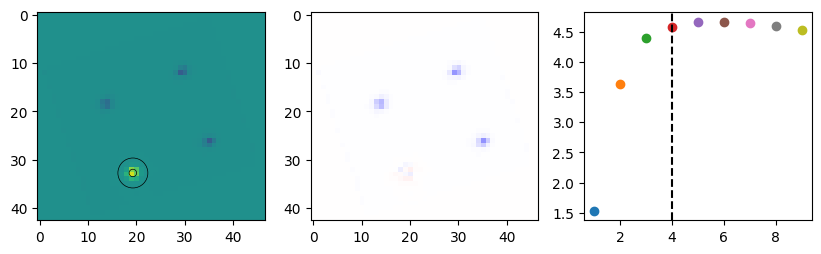

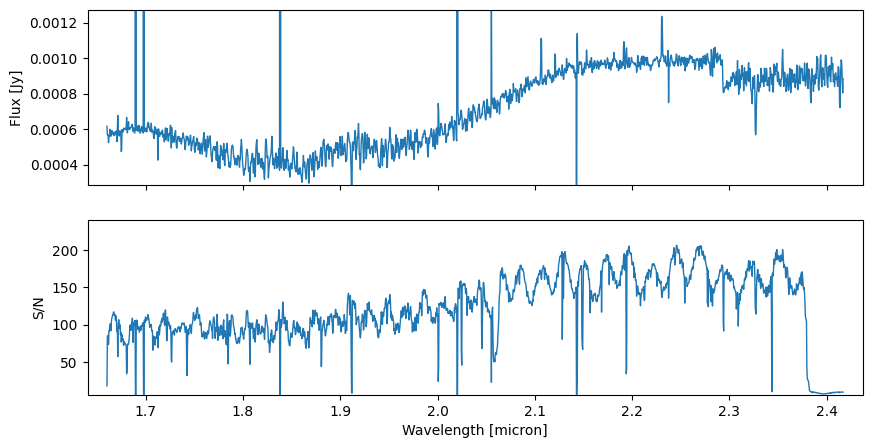

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


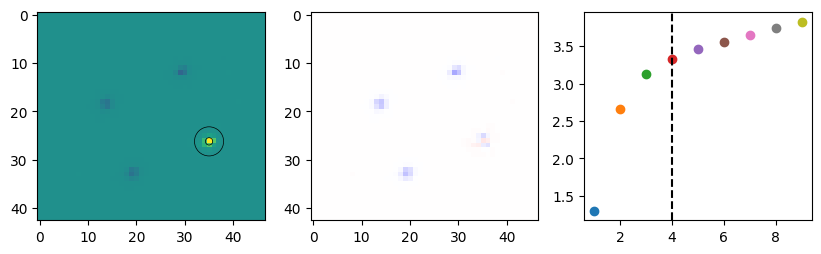

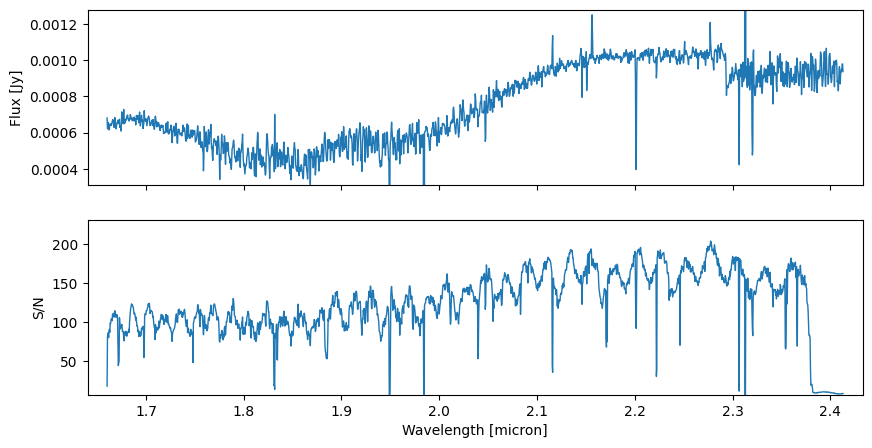

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


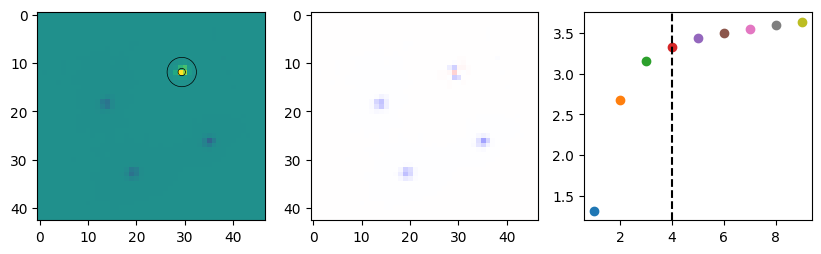

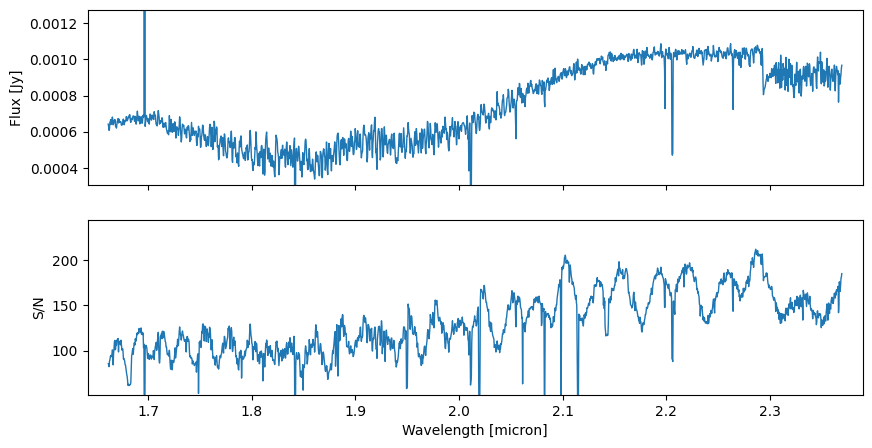

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


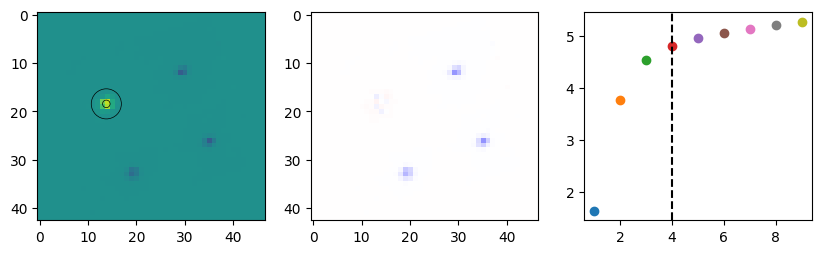

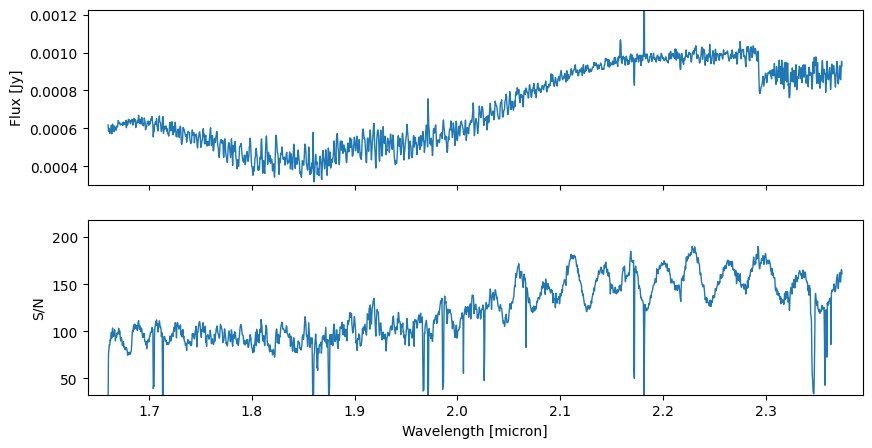

In [3]:
%matplotlib inline
#filename = './ifu_data_01386/MAST_2025-02-26T10_24_21.462Z/JWST/jw01386013001_{0}_{1:05d}/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
filename = './ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
xy_guess = [
    (19, 33), (28, 11), (13, 18), (35, 26), 
]
inf_coeff = 4

all_wave, all_flux, all_flux_err = [], [], []

detector = 'nrs1'
#grating = 'g140h'
grating = 'g235h'
#grating = 'g395h'
#for dither in range(1,5):
for dither in [1,4,2,3]:

    if grating == 'g140h':
        file_s3d = filename.format('03106', dither, detector, 's3d')
        file_x1d = filename.format('03106', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f100lp_g140h.txt'.format(detector[-1])
    elif grating == 'g235h':
        file_s3d = filename.format('03102', dither, detector, 's3d')
        file_x1d = filename.format('03102', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f170lp_g235h.txt'.format(detector[-1])
    elif grating == 'g395h':
        file_s3d = filename.format('03104', dither, detector, 's3d')
        file_x1d = filename.format('03104', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f290lp_g395h.txt'.format(detector[-1])

    wave, cube, cube_err = load_data(file_s3d=file_s3d, file_x1d=file_x1d)
    g_fit = fit_gaussian_2d(cube, xy_guess[dither-1], inf_coeff, plot=True)

    aper_kwargs = dict(
        positions=(g_fit.x_mean.value, g_fit.y_mean.value), theta=g_fit.theta.value, 
        a=g_fit.x_stddev.value*inf_coeff, b=g_fit.y_stddev.value*inf_coeff
        )
    flux, flux_err = extract_1d(wave, cube, cube_err, aper_kwargs, plot=True)

    all_wave.append(wave)
    all_flux.append(flux)
    all_flux_err.append(flux_err)

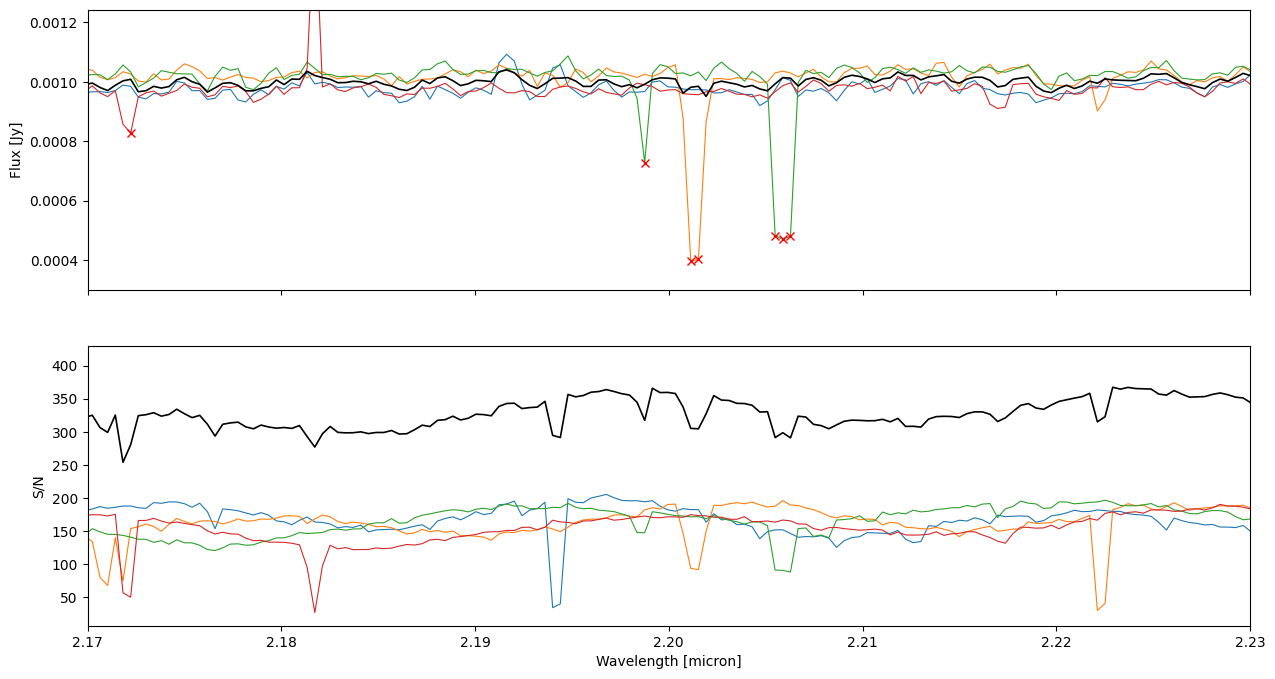

In [5]:
#wave_final, flux_final, flux_err_final = weighted_mean(all_wave, all_flux, all_flux_err, sigma_clip=15, plot=True, xlim=(1.7,1.8))
#wave_final, flux_final, flux_err_final = weighted_mean(all_wave, all_flux, all_flux_err, sigma_clip=20, plot=True)#, xlim=(5.1,5.3))
wave_final, flux_final, flux_err_final = weighted_mean(all_wave, all_flux, all_flux_err, sigma_clip=20, plot=True, xlim=(2.17,2.23))
flux_final, flux_err_final = convert_Jy_to_F_lam(wave_final, flux_final, flux_err_final)

#'''
# Save the results
np.savetxt(
    './Miles_ea_2023/reduction_27_02_2025/nirspec_{}_{}.dat'.format(grating[1:], detector[-1]), 
    np.array([wave_final, flux_final, flux_err_final]).T, delimiter=',', 
    header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )
#'''

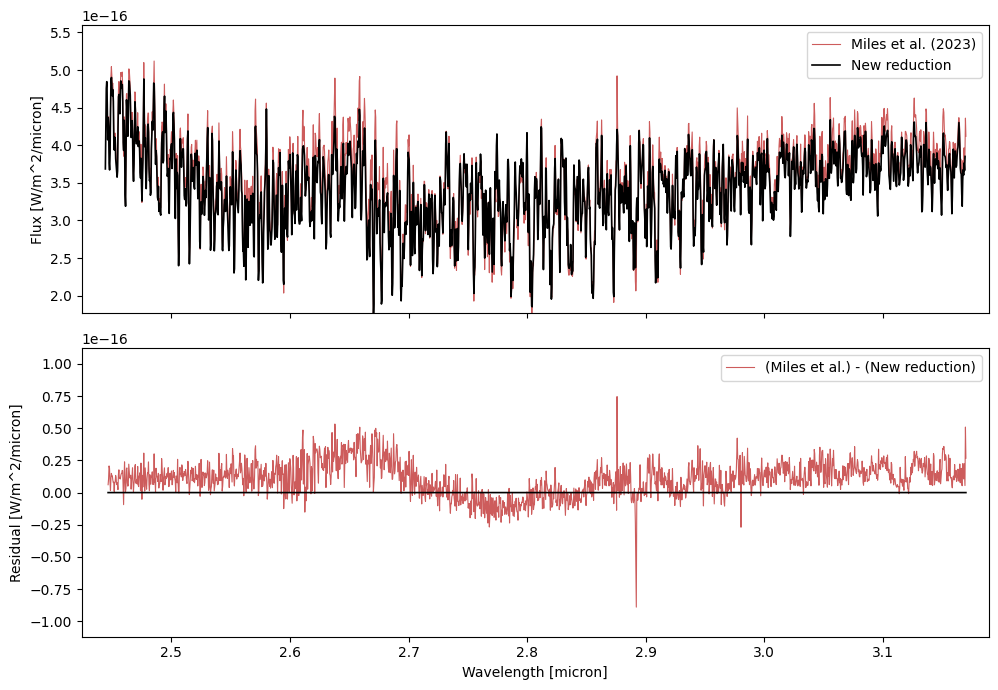

In [23]:
if grating == 'g140h':
    filter = 'f100lp'
elif grating == 'g235h':
    filter = 'f170lp'
elif grating == 'g395h':
    filter = 'f290lp'

# Load data from Miles et al. (2023)
file_Miles = './Miles_ea_2023/detector1_{}_{}.txt'.format(filter, grating)
wave_M1, flux_M1, flux_err_M1 = load_data_Miles_ea_2023(file_Miles)
wave_M2, flux_M2, flux_err_M2 = load_data_Miles_ea_2023(file_Miles.replace('detector1', 'detector2'))

wave_M = np.concatenate([wave_M1, wave_M2])
flux_M = np.concatenate([flux_M1, flux_M2])
flux_err_M = np.concatenate([flux_err_M1, flux_err_M2])

flux_M, flux_err_M = convert_Jy_to_F_lam(wave_M, flux_M, flux_err_M)

# Plot for comparison
xlim = (wave_final[np.isfinite(flux_final)][0]-0.02, wave_final[np.isfinite(flux_final)][-1]+0.02)
ylim = (np.nanpercentile(flux_final, 1)*1/1.2, np.nanpercentile(flux_final, 99)*1.2)

#%matplotlib ipympl
fig, ax = plt.subplots(figsize=(10,7), nrows=2, sharex=True)
ax[0].plot(wave_M, flux_M, lw=0.8, c='indianred', label='Miles et al. (2023)')
ax[0].plot(wave_final, flux_final, lw=1.2, c='k', label='New reduction')

ax[1].plot(wave_M, flux_M-np.interp(wave_M, wave_final, flux_final), lw=0.8, c='indianred', label='(Miles et al.) - (New reduction)')
ax[1].plot(wave_M, flux_M*0, lw=1.2, c='k')

ax[0].legend()
ax[1].legend()
ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [W/m^2/micron]')
#ax[0].set_xlim(2.19,2.22)

ax[1].set(ylim=(-ylim[1]*0.2, ylim[1]*0.2), ylabel='Residual [W/m^2/micron]', xlabel='Wavelength [micron]')
plt.tight_layout()
plt.savefig('./Miles_ea_2023/reduction_27_02_2025/nirspec_{}_{}.pdf'.format(grating[1:], detector[-1]))
plt.show()

## Extraction on combined dither-cube

In [ ]:
#grating = 'g140h'; filter = 'f100lp'
grating = 'g235h'; filter = 'f170lp'
#grating = 'g395h'; filter = 'f290lp'

file_s3d = './ifu_data_01386/stage3/Level3_{}-{}_s3d.fits'.format(grating, filter)
inf_coeff = 4

# Load data
wave, cube, cube_err = load_data(file_s3d, file_x1d=file_s3d.replace('s3d', 'x1d'))

# Locate the PSF
xy_guess = (cube.shape[2]//2+1, cube.shape[1]//2+1)
g_fit = fit_gaussian_2d(cube, xy_guess, inf_coeff, plot=True)

# Perform the 1D extraction
aper_kwargs = dict(
    positions=(g_fit.x_mean.value, g_fit.y_mean.value), 
    theta=g_fit.theta.value, 
    a=g_fit.x_stddev.value*inf_coeff, 
    b=g_fit.y_stddev.value*inf_coeff
    )
flux, flux_err = extract_1d(wave, cube, cube_err, aper_kwargs, plot=True)

# Convert to regular units
flux, flux_err = convert_Jy_to_F_lam(wave, flux, flux_err)

# Save the results
np.savetxt(
    #'./Miles_ea_2023/reduction_26_02_2025/nirspec_{}.dat'.format(grating), np.array([wave, flux, flux_err]).T, 
    delimiter=',', header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )

In [ ]:
# Load data from Miles et al. (2023)
file_Miles = './Miles_ea_2023/detector1_{}_{}.txt'.format(filter, grating)
wave_M1, flux_M1, flux_err_M1 = load_data_Miles_ea_2023(file_Miles)
wave_M2, flux_M2, flux_err_M2 = load_data_Miles_ea_2023(file_Miles.replace('detector1', 'detector2'))

wave_M = np.concatenate([wave_M1, wave_M2])
flux_M = np.concatenate([flux_M1, flux_M2])
flux_err_M = np.concatenate([flux_err_M1, flux_err_M2])

flux_M, flux_err_M = convert_Jy_to_F_lam(wave_M, flux_M, flux_err_M)

# Plot for comparison
xlim = (wave[np.isfinite(flux)][0]-0.02, wave[np.isfinite(flux)][-1]+0.02)
ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux, 99)*1.2)

fig, ax = plt.subplots(figsize=(14,7), nrows=2, sharex=True)
ax[0].plot(wave_M, flux_M, lw=0.8, c='indianred', label='Miles et al. (2023)')
ax[0].plot(wave, flux, lw=1.2, c='k', label='New reduction')

ax[1].plot(wave_M, flux_M-np.interp(wave_M, wave, flux), lw=0.8, c='indianred', label='(Miles et al.) - (New reduction)')
ax[1].plot(wave_M, flux_M*0, lw=1.2, c='k')

ax[0].legend()
ax[1].legend()
ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [W/m^2/micron]')
ax[0].set_xlim(2.18, 2.23)

ax[1].set(ylim=(-ylim[1]*0.2, ylim[1]*0.2), ylabel='Residual [W/m^2/micron]', xlabel='Wavelength [micron]')
plt.show()

In [1]:
'''
#filename = './ifu_data_01386/MAST_2025-02-26T10_24_21.462Z/JWST/jw01386013001_{0}_{1:05d}/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
filename = 'ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
file_s3d = filename.format('03102', 1, 'nrs1', 's3d')

file_s3d = 'ifu_data_01386/stage3/Level3_g235h-f170lp_s3d.fits'
hdu = fits.open(file_s3d)

cube     = hdu['SCI'].data
cube_err = hdu['ERR'].data

pixel_area = hdu['SCI'].header['PIXAR_SR']
cube     *= pixel_area * 1e6 # Convert to flux [MJy/sr] -> [Jy]
cube_err *= pixel_area * 1e6

for idx in [0,10,20,3814//2-5]:
    plt.imshow(cube[idx]/cube_err[idx])
    #plt.title('SNR at {:.4f} micron'.format(wave[idx]))
    plt.colorbar()
    plt.show()
'''
None